In [31]:
import pandas as pd
import os
from datetime import timedelta
import numpy as np
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
import random
%matplotlib inline

In [32]:
files = os.listdir('data_output/')
files = [i for i in files if 'csv' in i]
random.sample(files,10)

['378.csv',
 '190.csv',
 '425.csv',
 '399.csv',
 '276.csv',
 '250.csv',
 '244.csv',
 '163.csv',
 '372.csv',
 '143.csv']

In [7]:
# load the station to model
station_pred = 472
url = 'data_output/'
data = pd.read_csv(url+str(station_pred)+'.csv', index_col='date_time', parse_dates=True)

In [4]:
# self join data set offset on hours
for i in range(4,8):
    feature = pd.read_csv(url+str(station_pred)+'.csv', index_col='date_time', parse_dates=True)
    feature.index = feature.index - timedelta(minutes=(i*30))
    columns = [str(i*30)+'_'+ name for name in feature.columns]
    feature.columns = columns
    data = pd.concat([data,feature], axis=1, join='inner')

data=data[data.columns[3:]]

In [26]:
if (data.minutes_empty > 0).sum() / (len(data) * 1.0) > .005:
    'nothing'
else:
    print 'script'

In [11]:
# dummy weekdays
weekday = data.index.weekday
weekday = pd.DataFrame(weekday, index=data.index, columns=['weekday'])
dummies = pd.get_dummies(weekday.weekday, prefix='weekday')
dummies = dummies[dummies.columns[1:]]
data = pd.concat([data, dummies], axis=1)

In [115]:
# create the binary fields for y
data['minutes_full'] = (data.minutes_full > 0).astype(int)
data['minutes_empty'] = (data.minutes_empty > 0).astype(int)

# create features
feature_cols = [ i for i in data.columns[2:] if 'full' not in i and 'empty' not in i]
X = data[feature_cols]
y = data.minutes_empty

### Train n_estimators and max_features

In [11]:

scores = []
for i in range(10, 310, 10):
    rfclass = RandomForestClassifier(n_estimators=i, random_state=1)
    cross_val = cross_val_score(rfclass, X, y, cv=10, scoring='roc_auc').mean()
    scores.append(cross_val)

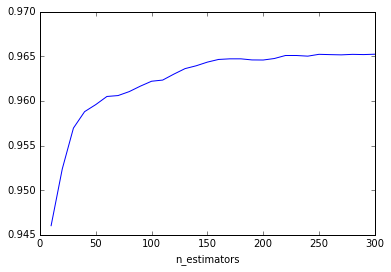

In [15]:
plt.plot(range(10, 310, 10), scores)
plt.xlabel('n_estimators')

In [86]:
number_features = len(X.columns.values)+1
scores = []
for i in range(1, number_features):
    rfclass = RandomForestClassifier(n_estimators=150, max_features=i, random_state=1)
    cross_val = cross_val_score(rfclass, X, y, cv=10, scoring='roc_auc').mean()
    scores.append(cross_val)

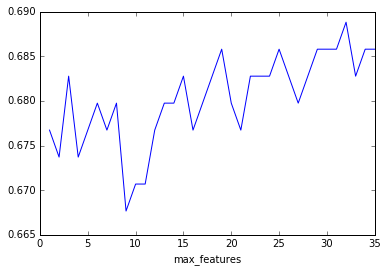

In [87]:
plt.plot(range(1, number_features), scores)
plt.xlabel('max_features')

### Model

In [118]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [121]:
len(feature_cols)

18

In [122]:
# model cross val
rfclass = RandomForestClassifier(n_estimators=150, max_features=18, random_state=1)
cross_val = cross_val_score(rfclass, X, y, cv=10, scoring='roc_auc').mean()
cross_val

0.95285869578194993

In [123]:
# model test train split
rfclass.fit(X_train, y_train)
y_pred = rfclass.predict(X_test)
confusion = metrics.confusion_matrix(y_test, y_pred)
TP = confusion[1,1] / ((confusion[1,0]+confusion[1,1])+1.0)

In [124]:
TP

0.67673716012084595

In [125]:
confusion

array([[4640,   83],
       [ 106,  224]])

In [126]:
feature_importance = pd.DataFrame({'feature':feature_cols, 'importance':rfclass.feature_importances_})
feature_importance.sort_values(by='importance',ascending=False ).head(10)

,feature,importance
1,120_min_count,0.396375
0,120_mean_count,0.320422
9,210_mean_count,0.050717
3,150_mean_count,0.050456
2,120_max_count,0.050240
6,180_mean_count,0.040576
14,weekday_3,0.011118
12,weekday_1,0.010494
13,weekday_2,0.010326
11,210_max_count,0.010206
